# Spam/Ham Email Classification

In this project, we will create a binary classifier that can distinguish spam (junk, commercial, or bulk) emails from ham (regular non-spam) emails. This project will first focus on initial analysis, feature engineering, and logistic regression before buildnig the actual spam/ham classifier and evaluating it.

In [1]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from datetime import datetime
from IPython.display import display, HTML

## The Data

In email classification, the goal is to classify emails as spam or not spam ("ham") using features generated from the text in the emails. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/) and consists of email messages and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8,348 labeled examples.

It should be noted that the dataset is from 2004, so the contents of the emails may be quite different from those today.

The `train` DataFrame will contain labeled data you will use to train the model. It has four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame will contain 1,000 emails that will be used for testing the model. Let's run the following cell to load the data into a DataFrame.

In [2]:
import zipfile

# Loading training and test datasets
with zipfile.ZipFile('spam_ham_data.zip') as item:
    with item.open("train.csv") as f:
        original_data = pd.read_csv(f)

## Preparing the Data

Before the data are used, it is crucial to preprocess the data and prepare it to be used later. Like with many data analyses, the first task we will do is identifying any null/missing values. Let's see how many of these there are in each column of the training data.

In [3]:
print('Before imputation:')
print(original_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64


It seems there are some emails with missing `subject` values. Because the subjects of the emails are not particularly important, they can simply be replaced with empty strings.

In [4]:
original_data = original_data.fillna('')
print('After imputation:')
print(original_data.isnull().sum())

After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


Excellent! Now there are no more null values in our data.

Before the data are split into separate training, validation, and testing sets, it would be very benecifial to first convert the contents of the emails to lowercase. It is possible to do this after as well, but it would require the same process be done for three different DataFrames.

In [5]:
# Convert the emails to lowercase as the first step of text processing
original_data['email'] = original_data['email'].str.lower()

original_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


## Splitting the Data

This data will be used for model training, validation, and testing. As mentioned previously, the size of the testing set `test` will be 1000. Also, to help with testing and debugging the code, the seed will be fixed to an arbitrary number.

In [6]:
# Create a train-test split on the labeled data
from sklearn.model_selection import train_test_split
train, test = train_test_split(original_data, test_size=1000, random_state=42)

# Preserve the ordering of emails to labels for the next part
train = train.reset_index(drop = True)

Next, we will split the training data into a training set named `train` and a validation set named `val`. A 90-10 split will be used to separate the training data into these two DataFrames.

In [7]:
# Create a 90/10 train-validation split on the labeled training data
train, val = train_test_split(original_data, test_size=0.1, random_state=42)

# Preserve the ordering of emails to labels for the next part
train = train.reset_index(drop = True)

## Parsing the Emails

Next, let's create a function that takes in a list of interesting words (words) and a Series of emails (texts). The goal is to check if each word in `words` is contained in the emails in `texts`.

As an example,
```
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))
```
should return
```
array([[1, 0, 0],
       [1, 0, 1]])
```

In [8]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts, and d is the number of words.
    """
    indicator_array = np.array([texts.str.contains(word) for word in words])
    return indicator_array.T

We will use this `words_in_texts` function to find occurrences of specific words (or strings of text) in the emails in the dataset. Doing some research on words commonly found in spam emails will result in words such as "body," "business," "html," "money," "offer," and "please." Let's visualize the proportion of ham and spam emails that contain these words.

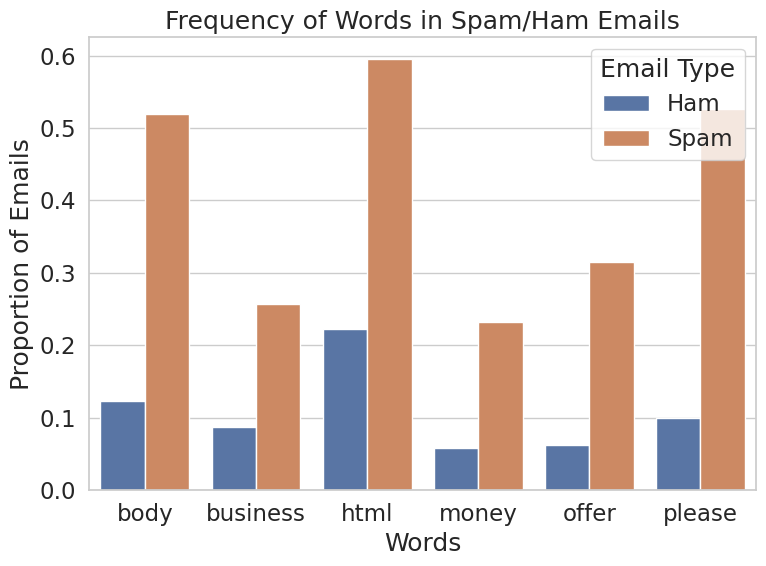

In [9]:
train = train.reset_index(drop=True) # Preserve the ordering of emails to labels for words_in_texts
plt.figure(figsize=(8,6))

words = ['body', 'business', 'html', 'money', 'offer', 'please']

indicators = pd.DataFrame(words_in_texts(words, train['email']), columns=words)
indicators['spam'] = train['spam']

proportions = indicators.groupby('spam')[words].mean().reset_index()
# Use melt to turn the columns of the original DataFrame into the entries of a variable column
melted_proportions = proportions.melt(id_vars='spam', var_name='word', value_name='proportion')
melted_proportions['type'] = melted_proportions['spam'].map({0: 'Ham', 1: 'Spam'})

sns.barplot(data=melted_proportions, x='word', y='proportion', hue='type')
plt.title("Frequency of Words in Spam/Ham Emails")
plt.xlabel("Words")
plt.ylabel("Proportion of Emails")
plt.legend(title='Email Type')
plt.tight_layout()
plt.show()

As expected, the words "body," "business," "html," "money," "offer," and "please" are much more prevalent in spam emails than in ham emails. This will be extremely useful for fitting a logistic regression model.

Next, let's visualize two specific aspects of the emails: the word count and the number of exclamation points. It should be no surprise that spam emails are usually longer and contain more exclamation marks to urge the recipient of the email to click on a link or respond in some way.

For reference, a spam label of 0 refers to the email being ham and a label of 1 referring to the email being spam.

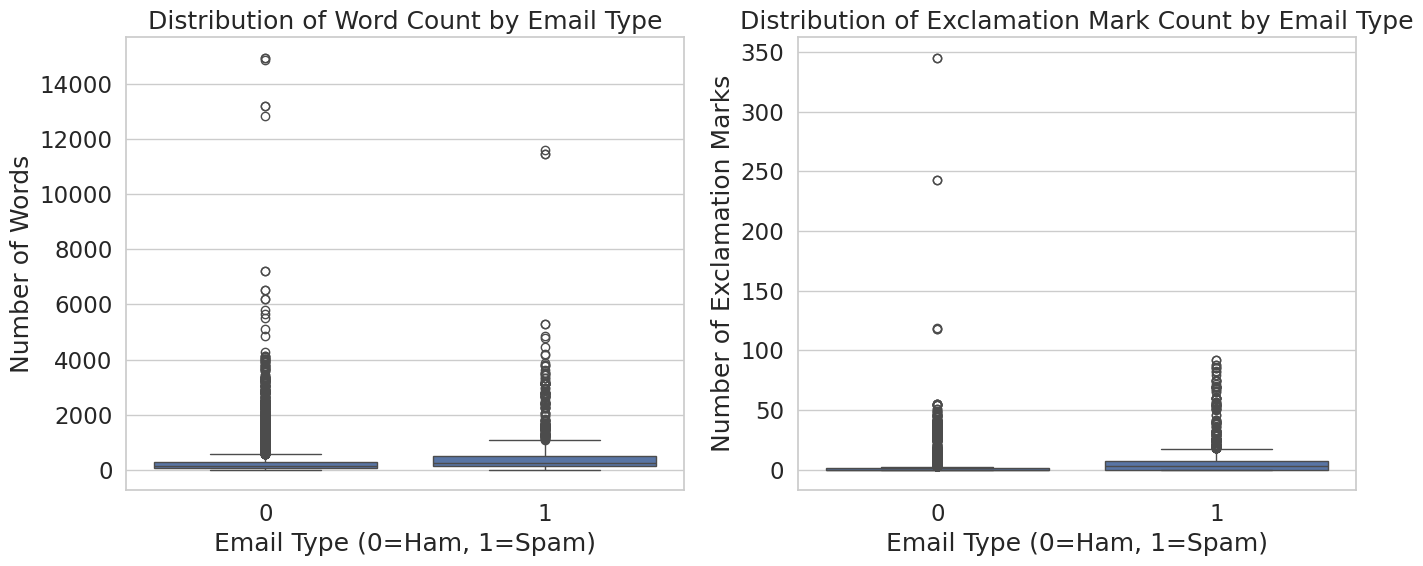

In [10]:
original_data['num_words'] = original_data['email'].apply(lambda x: len(x.split()))
original_data['num_exclamation_marks'] = original_data['email'].apply(lambda x: x.count('!'))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='spam', y='num_words', data=original_data, ax=axes[0])
axes[0].set_title('Distribution of Word Count by Email Type')
axes[0].set_xlabel('Email Type (0=Ham, 1=Spam)')
axes[0].set_ylabel('Number of Words')

sns.boxplot(x='spam', y='num_exclamation_marks', data=original_data, ax=axes[1])
axes[1].set_title('Distribution of Exclamation Mark Count by Email Type')
axes[1].set_xlabel('Email Type (0=Ham, 1=Spam)')
axes[1].set_ylabel('Number of Exclamation Marks')

plt.tight_layout()
plt.show()

The distributions have very heavy right skews, so let's try to linearize the data by taking the log of each.

/srv/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


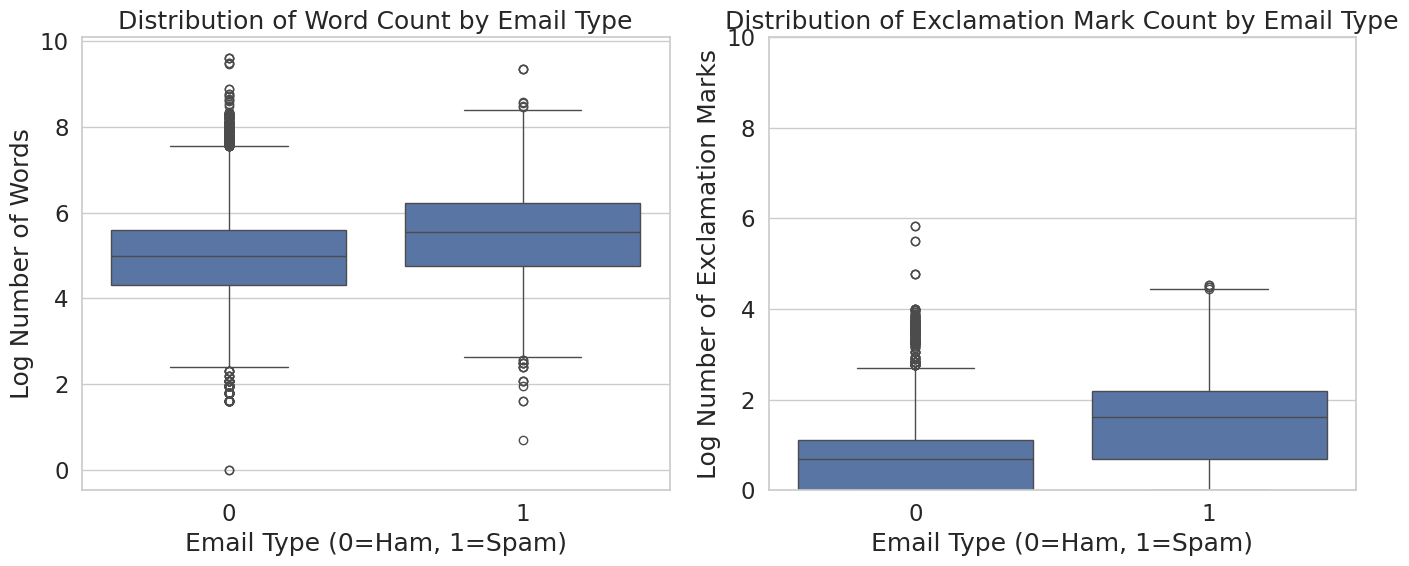

In [11]:
original_data['log_num_words'] = np.log(original_data['email'].apply(lambda x: len(x.split())))
original_data['log_num_exclamation_marks'] = np.log(original_data['email'].apply(lambda x: x.count('!')))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='spam', y='log_num_words', data=original_data, ax=axes[0])
axes[0].set_title('Distribution of Word Count by Email Type')
axes[0].set_xlabel('Email Type (0=Ham, 1=Spam)')
axes[0].set_ylabel('Log Number of Words')

sns.boxplot(x='spam', y='log_num_exclamation_marks', data=original_data, ax=axes[1])
axes[1].set_title('Distribution of Exclamation Mark Count by Email Type')
axes[1].set_xlabel('Email Type (0=Ham, 1=Spam)')
axes[1].set_ylabel('Log Number of Exclamation Marks')
axes[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

The results are interesting. For the number of words in the emails, there appear to be more words in spam emails on average, as well as a wider spread. Interestingly, there are much more outliers for ham emails than for spam emails (mathematically). On the other hand, the distributions of the number of exclamation points are much more clear. As expected, there are significantly more exclamation points in spam emails than in ham emails on average.

Additionally, let's take a look at a ham email and a spam email to see if there are any other distinguishing details regarding their contents.

In [12]:
first_ham = original_data.loc[original_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_data.loc[original_data['spam'] == 1, 'email'].iloc[0]
print("Ham Email:")
print(first_ham)
print("-------------------------------------------------")
print("Spam Email:")
print(first_spam)

Ham Email:
url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-------------------------------------------------
Spam Email:
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



It seems that other strings we can search for are html tags. Let's use words_in_texts again to visualize the proportion of ham/spam emails that contain the tags "body," "html," "img", "div" and "span." These tags should be much more prevalent in spam emails.

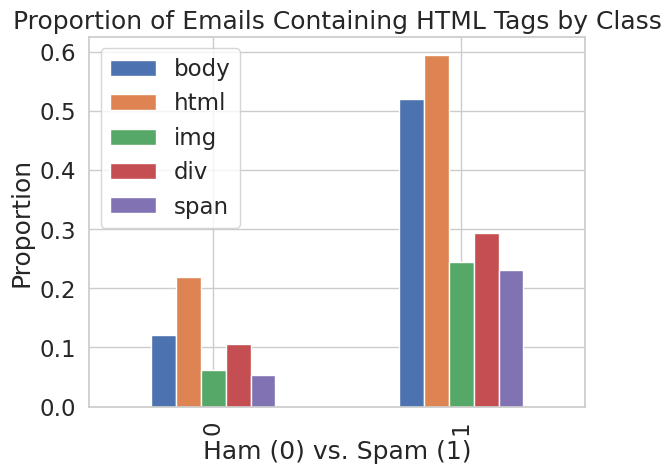

In [13]:
html_tags = ['body', 'html', 'img', 'div', 'span']
indicators = words_in_texts(html_tags, original_data['email'])

original_data[html_tags] = pd.DataFrame(indicators, columns=html_tags)
proportions_html = original_data.groupby('spam')[['body', 'html', 'img', 'div', 'span']].mean()

proportions_html.plot(kind='bar')
plt.title("Proportion of Emails Containing HTML Tags by Class")
plt.xlabel("Ham (0) vs. Spam (1)")
plt.ylabel("Proportion")
plt.legend(html_tags)
plt.show()

As expected, the tags "body," "html," "img", "div" and "span" are much more prevalent in spam emails than in ham emails. This will also be helpful for fitting a model later.

## Classification

Next, let's do some basic classification using the six words form above: "body," "business," "html," "money," "offer," and "please."

In [14]:
from sklearn.linear_model import LogisticRegression

some_words = ['business', 'money', 'offer', 'please', 'reply']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam'].values

my_model = LogisticRegression()
my_model.fit(X_train, Y_train)

Y_train_pred = my_model.predict(X_train)

training_accuracy = np.mean(Y_train_pred == Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.8203114601357647


The initial accuracy of .82 is not bad. Let's evaulate it on the validation set.

In [15]:
X_val = words_in_texts(some_words, val['email'])
Y_val = val['spam'].values

Y_val_pred = my_model.predict(X_val)

validation_accuracy = np.mean(Y_val_pred == Y_val)
print("Validation Accuracy: ", validation_accuracy)

Validation Accuracy:  0.8011976047904191


It appears the validation accuracy is slightly lower, which could perhaps indicate overfitting. However, the difference is small, and the current model does not use very many features, so let's implement two more features, both of which will be numeric: the log number of words in the email, and the log number of exclamation points in the email. Recall from earlier that the log is used as the distribution of both are heavily right-skewed. Also, we will need to add 1 to each value to avoid taking the log of 0 as some emails have 0 words and/or 0 exclamation points.

In [16]:
words_to_check = ['business', 'money', 'offer', 'please', 'reply']
word_indicators = words_in_texts(words_to_check, train['email'])
word_indicators_df = pd.DataFrame(word_indicators, columns=words_to_check)
train = pd.concat([train, word_indicators_df], axis=1)

train['log_num_words'] = np.log(train['email'].apply(lambda x: len(x.split()) + 1))
train['log_num_exclamation_marks'] = np.log(train['email'].apply(lambda x: x.count('!') + 1))

X_train = train[['log_num_words', 'log_num_exclamation_marks'] + words_to_check].values
Y_train = train['spam'].values

my_model = LogisticRegression(max_iter=1000)
my_model.fit(X_train, Y_train)

Y_train_pred = my_model.predict(X_train)

training_accuracy = np.mean(Y_train_pred == Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.8337548249700519


Let's see the validation accuracy.

In [17]:
val = val.reset_index(drop=True)
word_indicators_val = words_in_texts(words_to_check, val['email'])
word_indicators_val_df = pd.DataFrame(word_indicators_val, columns=words_to_check)
val = pd.concat([val, word_indicators_val_df], axis=1)

val['log_num_words'] = np.log(val['email'].apply(lambda x: len(x.split()) + 1))
val['log_num_exclamation_marks'] = np.log(val['email'].apply(lambda x: x.count('!') + 1))

X_val = val[['log_num_words', 'log_num_exclamation_marks'] + words_to_check].values
Y_val = val['spam'].values

Y_val_pred = my_model.predict(X_val)

validation_accuracy = np.mean(Y_val_pred == Y_val)
print("Validation Accuracy: ", validation_accuracy)

Validation Accuracy:  0.8359281437125748


The model is doing better now that the two new features (log word count and log count of exclamation points) were implemented. Interestingly, the validation accuracy is now very slightly higher than the training accuracy, dispelling any suspicions of overfitting.

Finally, let's add the html tags to the model.

In [18]:
html_tags = ['body', 'html', 'img', 'div', 'span']

html_tag_indicators = words_in_texts(html_tags, train['email'])
html_tag_indicators_df = pd.DataFrame(html_tag_indicators, columns=html_tags)
train = pd.concat([train, html_tag_indicators_df], axis=1)

X_train = train[['log_num_words', 'log_num_exclamation_marks'] + words_to_check + html_tags].values
Y_train = train['spam'].values

my_model = LogisticRegression(max_iter=1000)
my_model.fit(X_train, Y_train)

Y_train_pred = my_model.predict(X_train)

training_accuracy = np.mean(Y_train_pred == Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.8610408625049913


Validation:

In [19]:
html_tag_indicators = words_in_texts(html_tags, val['email'])
html_tag_indicators_df = pd.DataFrame(html_tag_indicators, columns=html_tags)
val = pd.concat([val, html_tag_indicators_df], axis=1)

X_val = val[['log_num_words', 'log_num_exclamation_marks'] + words_to_check + html_tags].values
Y_val = val['spam'].values

Y_val_pred = my_model.predict(X_val)

validation_accuracy = np.mean(Y_val_pred == Y_val)
print("Validation Accuracy: ", validation_accuracy)

Validation Accuracy:  0.8694610778443114


The accuracy of the model is now even higher, which is excellent. Before testing the model on the testing set, however, let us also adjust the decision threshold of the model.

Scikit-learn uses a decision threshold of .5 by default. In other words, if the prediction for one point is greater than or equal to .5, then it would be classified as spam and vice versa. One way the model could be improved is by adjusting this threshold. To help with this task, let's look at some metrics other than accuracy: precision, recall, and F1 score.

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
threshold = 0.5
Y_val_probs = my_model.predict_proba(X_val)[:, 1]
Y_val_pred_adjusted = (Y_val_probs >= threshold).astype(int)

accuracy = accuracy_score(Y_val, Y_val_pred_adjusted)
precision = precision_score(Y_val, Y_val_pred_adjusted)
recall = recall_score(Y_val, Y_val_pred_adjusted)
f1 = f1_score(Y_val, Y_val_pred_adjusted)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8695
Precision: 0.8383
Recall: 0.6306
F1 Score: 0.7198


Now let's look at the ROC curve for the model and find the optimal threshold (recall that the default is .5).

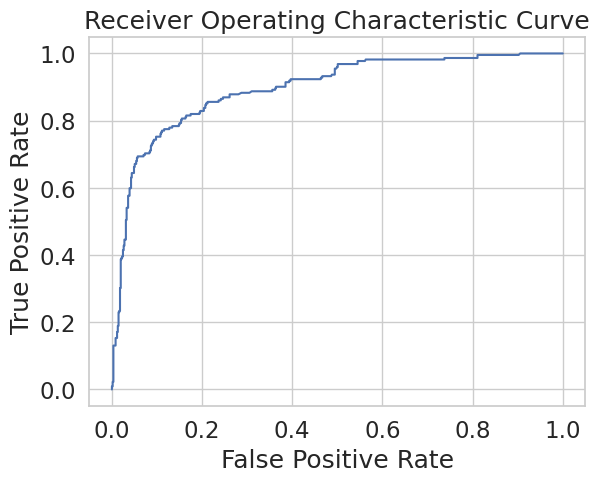

Optimal Threshold: 0.3085498311330298


In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_val, Y_val_probs)

plt.plot(fpr, tpr)
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

Based on this, the optimal threshold appears to be about .309, which is quite a bit lower than .5. Let's evaluate the same model using this new threshold:

In [22]:
Y_val_pred_adjusted = (Y_val_probs >= optimal_threshold).astype(int)

adjusted_accuracy = accuracy_score(Y_val, Y_val_pred_adjusted)
adjusted_precision = precision_score(Y_val, Y_val_pred_adjusted)
adjusted_recall = recall_score(Y_val, Y_val_pred_adjusted)
adjusted_f1 = f1_score(Y_val, Y_val_pred_adjusted)

print(f"Accuracy: {adjusted_accuracy:.4f}")
print(f"Precision: {adjusted_precision:.4f}")
print(f"Recall: {adjusted_recall:.4f}")
print(f"F1 Score: {adjusted_f1:.4f}")

Accuracy: 0.8575
Precision: 0.7155
Recall: 0.7703
F1 Score: 0.7419


At the cost of about 1% of accuracy and about 12% of precision, we were able to improve the recall byabout 14% and the F1 score by about 2%. But what does this actually mean?

Well, if missing a spam email (false negative) is worse than flagging a ham email (false positive), this is a good trade-off. For example, this would be important for security alerts or phishing detection systems that should prioritize recall. On the other hand, if falsely marking too many legitimate emails as spam (false positives) is unacceptable, then a higher precision model would be preferred.

Usually, it is very easy to determine whether an email is spam just by looking at it. As a regular Internet user, identifying whether an email is spam is very easy, so it not a big deal at all if a spam email bypasses the filter. I would personally prefer to maximize precision in order to miss as few important emails as possible, and if a spam email does appear in my inbox, then it would be no big deal as I would easily be able to identify it as such. Because of this, I would stick with the threshold of .5. At the end of the day, though, it is be up to the individual user to decide what to prioritize.

In [23]:
words_to_check = ['business', 'money', 'offer', 'please', 'reply']
html_tags = ['body', 'html', 'img', 'div', 'span']
test = test.reset_index(drop=True)

word_indicators_test = words_in_texts(words_to_check, test['email'])
word_indicators_df_test = pd.DataFrame(word_indicators_test, columns=words_to_check)
test = pd.concat([test, word_indicators_df_test], axis=1)

test['log_num_words'] = np.log(test['email'].apply(lambda x: len(x.split()) + 1))
test['log_num_exclamation_marks'] = np.log(test['email'].apply(lambda x: x.count('!') + 1))

html_tag_indicators_test = words_in_texts(html_tags, test['email'])
html_tag_indicators_df_test = pd.DataFrame(html_tag_indicators_test, columns=html_tags)
test = pd.concat([test, html_tag_indicators_df_test], axis=1)
X_test = test[['log_num_words', 'log_num_exclamation_marks'] + words_to_check + html_tags].values

Y_test_pred_proba = my_model.predict_proba(X_test)[:, 1]

threshold = 0.5 # Explanation made above
Y_test_pred_adjusted = (Y_test_pred_proba >= threshold).astype(int)

accuracy_test = accuracy_score(test['spam'], Y_test_pred_adjusted)
precision_test = precision_score(test['spam'], Y_test_pred_adjusted)
recall_test = recall_score(test['spam'], Y_test_pred_adjusted)
f1_test = f1_score(test['spam'], Y_test_pred_adjusted)

print(f"Testing Accuracy: {accuracy_test:.4f}")
print(f"Testing Precision: {precision_test:.4f}")
print(f"Testing Recall: {recall_test:.4f}")
print(f"Testing F1 Score: {f1_test:.4f}")

Testing Accuracy: 0.8680
Testing Precision: 0.8365
Testing Recall: 0.6397
Testing F1 Score: 0.7250


Let's take a look at what we did. This project focused on building a logistic regression model to classify emails as spam or ham, leveraging features such as specific keyword indicators, email length, number of exclamation marks, and presence of HTML tags. Through a step-by-step process of feature engineering, model evaluation, and threshold tuning, the model achieved a testing accuracy of 86.8%, with a balanced performance reflected in an F1 score of 0.7250.

The key takeaway from this project is the trade-off between precision and recall. While the model performs well in terms of precision (83.65%), it could still be improved in recall (63.97%) by lowering the threshold. This suggests that there is an opportunity to further fine-tune the threshold to improve recall, possibly at the cost of some precision, depending on the specific use case and the importance of minimizing false positives or false negatives.

Moving forward, there are multiple ways to enhance the model's performance, such as exploring other machine learning algorithms (e.g., Random Forest, Naive Bayes, etc.), experimenting with more advanced feature extraction techniques like TF-IDF or word embeddings, and performing more detailed threshold adjustments based on business goals. Furthermore, incorporating additional metrics such as the ROC curve could provide deeper insights into the model's performance across different thresholds. However, this project is already quite long, so those ideas will be reserved for a future project.

Ultimately, this project demonstrates the importance of not only developing a model but also iterating on it based on evaluation metrics to ensure it aligns with real-world and personal needs. The experience gained from this project can be applied to similar challenges in classification tasks, such as text classification, sentiment analysis, or other applications requiring automated decision-making.